# Chapter 02 - Unconstrained optimization

In [24]:
# Import required packages
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import mpld3

# Set plot to use TeX for rendering equations.
plt.rcParams["text.usetex"] = True


## Figure 2.1 

A exemplary function $f$ defined on a two-dimensional domain to visualize the optimization problem as a search for the minimum in a "mountaineous landscape".

In [25]:
def f(x):
    # This is a slight modification of Himmelblau's function
    return (x[...,0]**2 + x[...,1] - 11) ** 2 + (x[...,0] + x[...,1]**2 - 7) ** 2 + x[...,0] + x[...,1]

# Define the two-dimensional plot domain
x1 = torch.linspace(-5, 5, steps=100)
x2 = torch.linspace(-5, 5, steps=100)
x = torch.stack(torch.meshgrid(x1, x2, indexing="xy"), dim=2)

# Create subplots
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "surface"}]])
fig.add_trace(go.Contour(z=f(x), x=x1, y=x2, ncontours=25), row=1, col=1)
fig.add_trace(go.Surface(z=f(x), x=x1, y=x2), row=1, col=2)

# Plot settings
fig.update_traces(showscale=False)
fig.update_layout(autosize=False, width=1000, height=500)
fig.show()


## Example 9

The function $f_0(x, y)=x^2 + y^2$ is convex, as its Hessian 
$$
        \nabla^2f_0(x,y) = 
        \begin{pmatrix}
        2 & 0 \\ 
        0       & 2         
        \end{pmatrix}
$$
is positive definite. Visually this means, we can draw a line between any two points of the function and it will never intersect the function.

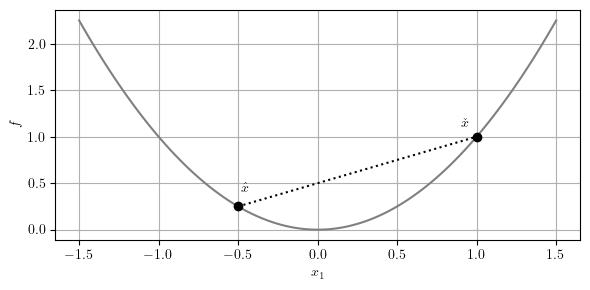

In [26]:
# Domain
x = torch.linspace(-1.5, 1.5, 100)

# Plot the function
fig = plt.figure(figsize=(6, 3))
plt.plot(x, x**2, "gray")

# Plot settings
plt.plot([-0.5, 1], [0.25, 1], ":k")
plt.annotate("$\hat{x}$", [-0.48, 0.4])
plt.plot([-0.5], [0.25], "ok")
plt.plot([1.0], [1.0], "ok")
plt.annotate("$\check{x}$", [0.9, 1.1])
plt.xlabel("$x_1$")
plt.ylabel("$f$")
plt.grid()
plt.tight_layout()
plt.savefig("../figures/convex_function_0.pdf", transparent=True)
plt.savefig("../figures/convex_function_0.svg", transparent=True)
plt.show()



## Example 10

The function $f_1(x, y)=x^4-x^2+y^2$ is not strictly convex, because its Hessian 
$$
    \nabla^2f_1(x,y) = 
    \begin{pmatrix}
    12x^2-2 & 0 \\ 
    0       & 2         
    \end{pmatrix}
$$
is not positive definite. Visually this means, we can find two points, for which drawing a line between them would cross the function. 

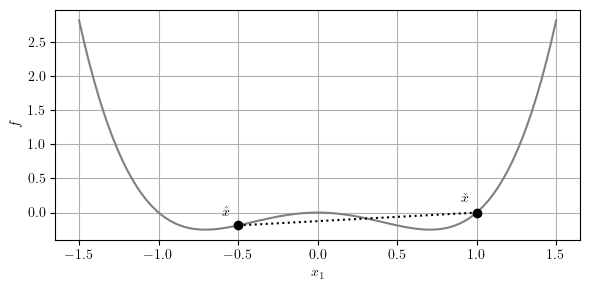

In [27]:
# Domain
x = torch.linspace(-1.5, 1.5, 100)

# Plot the functiom
fig = plt.figure(figsize=(6, 3))
plt.plot(x, x**4 - x**2, "gray")

# Plot settings
plt.plot([-0.5, 1], [-0.1875, 0], ":k")
plt.annotate("$\hat{x}$", [-0.6, -0.05])
plt.annotate("$\check{x}$", [0.9, 0.15])
plt.plot([-0.5], [-0.1875], "ok")
plt.plot([1.0], [0.0], "ok")
plt.xlabel("$x_1$")
plt.ylabel("$f$")
plt.grid()
plt.tight_layout()
plt.savefig("../figures/convex_function_1.pdf", transparent=True)
plt.savefig("../figures/convex_function_1.svg", transparent=True)
plt.show()

## Example 12

Consider the function $f(x)$ displayed below. The Armijo condition is satisfied in all green ranges.  

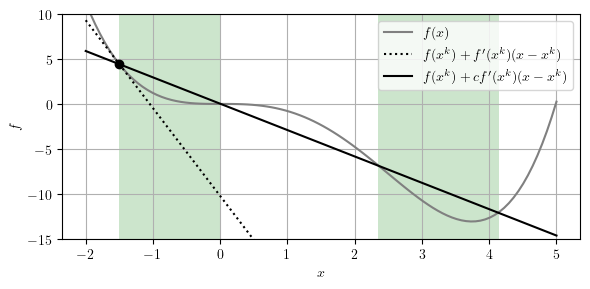

In [28]:
# Domain
x = torch.linspace(-2, 5, 100)

# Function
f = lambda x: (0.1 * x) ** 2 - x**3 + 0.2 * x**4
# Analytical derivative 
f_d = lambda x: 0.2 * x - 3 * x**2 + 0.8 * x**3
# Linearization
g = lambda x, c: f(-1.5) + c * f_d(-1.5) * (x + 1.5)

# Plot lines
fig = plt.figure(figsize=(6, 3))
plt.plot(x, f(x), "gray", label="$f(x)$")
plt.plot(x, g(x, 1), ":k", label="$f(x^k) + f'(x^k) (x-x^k)$")
plt.plot(x, g(x, 0.3), "-k", label="$f(x^k) + c f'(x^k) (x-x^k)$")
plt.plot([-1.5], [f(-1.5)], "ok")

# Mark regions
rect = patches.Rectangle(
    (-1.5, -15), 1.5, 25, linewidth=1, facecolor="green", alpha=0.2
)
plt.gca().add_patch(rect)
rect = patches.Rectangle(
    (2.35, -15), 1.8, 25, linewidth=1, facecolor="green", alpha=0.2
)
plt.gca().add_patch(rect)

# Plot settings
plt.ylim([-15, 10])
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("../figures/armijo_condition.pdf", transparent=True)
plt.savefig("../figures/armijo_condition.svg", transparent=True)
plt.show()


## Example 15: Newton's method

Consider the nonlinear function $f(x) = x^2 - 3$ displayed below. To find a root, i.e. the values of $x$ where $f(x)=0$, we can employ Newtons method: 
1. Pick a starting point $x^0$.
2. Compute the derivative $f'(x)$.
3. Compute a new point $x^{k+1} = x^k - \frac{f(x^k)}{f'(x^k)}$.
4. Repeat the steps 2 and 3 until converged.

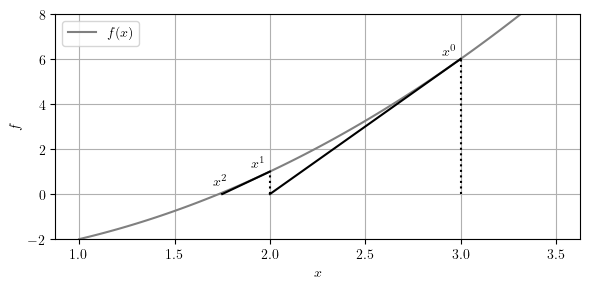

In [29]:
# Domain
x = torch.linspace(1, 3.5, 100)
# Domain for first linearization
xx = torch.linspace(2, 3, 100)
# Domain for second linearization
xxx = torch.linspace(1.75, 2, 100)

# Define the function
f = lambda x: x**2 - 3
# Analytical derivative of the function
f_d = lambda x: 2 * x
# First linearization
g = lambda x: f(3.0) + f_d(3) * (x - 3)
# Second linearization
h = lambda x: f(2.0) + f_d(2) * (x - 2)

# Plot lines and annotations
fig = plt.figure(figsize=(6, 3))
plt.plot(x, f(x), "gray", label="$f(x)$")
plt.plot([3, 3], [0, 6], ":k")
plt.annotate("$x^0$", [2.9, 6.15])
plt.plot(xx, g(xx), "-k")
plt.plot([2, 2], [0, 1], ":k")
plt.annotate("$x^1$", [1.9, 1.2])
plt.plot(xxx, h(xxx), "-k")
plt.plot([1.75, 1.75], [0, 0.0625], ":k")
plt.annotate("$x^2$", [1.7, 0.4])

# Plot settings
plt.ylim([-2, 8])
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("../figures/netwon_iteration.pdf", transparent=True)
plt.savefig("../figures/netwon_iteration.svg", transparent=True)
plt.show()
